# Segmenting Retinal Blood Vessels

Tworzymy klasy pomocnicze:
- ProcessImage - statyczna klasa zajmująca się przetwarzaniem obrazu
- Classifier - klassa wykorzystująca  biblioteki do predykcji połorzenia naczyń na obrazie

In [85]:
import math
import cv2
from sklearn.neighbors import KNeighborsClassifier
from processImage import ProcessImage
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from skimage import morphology
from IPython.display import display
from PIL import Image

In [86]:
class ProcessImage:

    # def __init__(self):
    #     self.mask = None

    def slice_img(src_img, size):
        slices = []
        for x in range(size - 1, src_img.shape[0] - size, 1):
            for y in range(size - 1, src_img.shape[1] - size, 1):
                slices.append(src_img[x:x+size, y:y+size])

        return slices

    def get_hu(src_img_part):
        moments = cv2.moments(src_img_part)
        huMoments = cv2.HuMoments(moments)
        # Log scale hu moments
        for i in range(0, 7):
            if huMoments[i] != 0:
                huMoments[i] = -1 * math.copysign(1.0, huMoments[i]) * math.log10(abs(huMoments[i]))

        flat_huMoments = [item for sublist in huMoments for item in sublist]
        return flat_huMoments


    def extract_green(src_img):
        _, green_channel, _ = cv2.split(src_img)  # split img into 3 channels: blue, green, red
        return green_channel

    def resize_img(src_img, scale=1.0):
        if scale != 1.0:
            h, w, _ = src_img.shape
            h = int(h * scale)
            w = int(w * scale)
            resized_img = cv2.resize(src_img, (w, h), interpolation=cv2.INTER_LINEAR)
            return resized_img
        else:
            return src_img

    def min_max_snap(src_img, limit=7.):
        w, h = src_img.shape
        new_img = np.zeros_like(src_img)
        for i in range(w):
            for j in range(h):
                # img[i][j] = int(img[i][j] * 255)
                new_img[i][j] = 255 if src_img[i][j] > limit else 0

        return new_img

    def prepare_mask(src_img, border_size=3):
        src_img = src_img.astype(np.uint8)
        mask = ProcessImage.min_max_snap(src_img, limit=1)
        kernel = np.ones((border_size, border_size), np.uint8)
        mask = cv2.erode(mask, kernel, iterations=1)
        return mask

    def preprocess(src_img):
        img = ProcessImage.resize_img(src_img.copy(), scale=1.0)
        img = ProcessImage.extract_green(img)
        # to ma w zalozeniu pozbyc sie tego swiatla ktore dzieli duze vessele na 2
        # kernel = np.ones((5, 5), np.uint8)
        # img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

        mask = ProcessImage.prepare_mask(img, border_size=25)
        cv2.imwrite('mask.jpg', mask)
        img = cv2.bitwise_and(img, img, mask=mask)

        # zwiększenie kontrastu
        clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(9, 9))
        img = clahe.apply(img)

        # maska na zewnętrzny okrąg
        # self.mask = self.prepare_mask(img, border_size=25)

        # zastosowanie filtru frangi
        # img = (frangi(img))
        # img = (img * 255).astype(np.uint8)

        # Mialoby pomoc wypelnic vessele po filtru frangi ale nie dziala dobrze xD
        # kernel = np.ones((6, 6), np.uint8)
        # img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        # kernel = np.ones((3, 3), np.uint8)
        # img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

        # binaryzacja obrazu
        # img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

        #cv2.imshow('img', img_sliced[26])
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()

        return img


In [87]:
class Classifier:
    def __init__(self, trainImages_x, trainImages_y, n_neighbors=5, sliceSize=5):
        self.sliceSize = sliceSize
        self.model = KNeighborsClassifier(n_neighbors=n_neighbors)
        self.x_train, self.y_train = [], []
        print('Iterating through train images')
        # slice obrazu oraz obliczanie hu momentów dla każdej jego części
        for img in trainImages_x:
            img_sliced = ProcessImage.slice_img(img, self.sliceSize)
            for img_part in img_sliced:
                flat_img = [item for sublist in img_part for item in sublist]
                while len(flat_img) < self.sliceSize * self.sliceSize:
                    flat_img.append(flat_img[0])

                moments = list(cv2.moments(img_part).values())
                huMoments = ProcessImage.get_hu(img_part)
                allMoments = np.append(moments, huMoments)

                self.x_train.append(huMoments)

        print('Iterating through train expert images')
        # slice obrazu eksperckiego i wybieranie jego centralnego punktu
        for img in trainImages_y:
            img_sliced = ProcessImage.slice_img(img, self.sliceSize)
            for img_part in img_sliced:
                center_pixel = img_part[self.sliceSize//2][self.sliceSize//2]
                self.y_train.append(center_pixel)

        print('Undersampling...')
        rus = RandomUnderSampler(random_state=0)
        self.x_train, self.y_train = rus.fit_resample(self.x_train, self.y_train)

        self.x_train = np.array(self.x_train)
        self.y_train = np.array(self.y_train)
        print('Training...')
        self.model.fit(self.x_train, self.y_train)

    def predict(self, predictImage):
        print('Preparing predict image')
        img_sliced = ProcessImage.slice_img(predictImage, self.sliceSize)
        testCases = []
        for img_part in img_sliced:
            flat_img = [item for sublist in img_part for item in sublist]
            while len(flat_img) < self.sliceSize * self.sliceSize:
                flat_img.append(flat_img[0])

            moments = list(cv2.moments(img_part).values())
            huMoments = ProcessImage.get_hu(img_part)
            allMoments = np.append(moments, huMoments)
            testCases.append(huMoments)

        print('Predicting...')
        y_pred = self.model.predict(testCases)
        print('Predicted.')
        predicted_image = np.zeros_like(predictImage)
        i = 0
        for x in range(self.sliceSize - 1, predictImage.shape[0] - self.sliceSize, 1):
            for y in range(self.sliceSize - 1, predictImage.shape[1] - self.sliceSize, 1):
                predicted_image[x, y] = y_pred[i]
                i += 1
        cv2.imwrite('temp.jpg', predicted_image)
        return predicted_image




Funkcja oceniająca jakość predykcji:

In [88]:
def evaluate(prediction, true_model, imbalanced_data=False):
    if prediction.shape != true_model.shape:
        return -1
    if len(prediction.shape) != 2:
        return -2
    h, w = prediction.shape
    conf_image = np.zeros((h, w, 3))

    TP, FP, FN, TN = 0, 0, 0, 0
    for r in range(w):
        for c in range(h):
            if prediction[c][r] == true_model[c][r] == 255:
                TP += 1
                conf_image[c][r] = 255, 255, 255
            elif prediction[c][r] == true_model[c][r] == 0:
                TN += 1
                conf_image[c][r] = 0, 0, 0
            elif prediction[c][r] != true_model[c][r] and prediction[c][r] == 255:
                FP += 1
                conf_image[c][r] = 0, 0, 255  # BGR
            elif prediction[c][r] != true_model[c][r] and prediction[c][r] == 0:
                FN += 1
                conf_image[c][r] = 0, 255, 0  # BGR
            else:
                print(prediction[c][r], true_model[c][r])
                return -3

    accuracy = (TP+TN)/(TP+TN+FN+FP)
    sensitivity = TP/(TP+FN)
    specifity = TN/(FP+TN)
    try:
        precision = TP/(TP+FP)
    except:
        print('No positive values found')
        return np.zeros_like(prediction.shape)
    print('Accuracy: ', accuracy)
    print('Sensitivity: ', sensitivity)
    print('Specifity: ', specifity)
    print('Precision: ', precision)
    if imbalanced_data:
        print('G-Mean: ', math.sqrt(sensitivity*specifity))
        print('F-measure: ', (2*precision*sensitivity)/(precision+sensitivity))
    return conf_image


In [89]:
train_imgs = []
expert_imgs = []
for i in range(4, 5):
    train_img_path = 'data/Image_0' + str(i) + 'L.jpg'
    train_img = cv2.imread(train_img_path)
    train_img = ProcessImage.preprocess(train_img)
    train_imgs.append(train_img)

    expert_img_path = 'goal/Image_0' + str(i) + 'L_1stHO.png'
    expert_img = cv2.imread(expert_img_path, cv2.IMREAD_GRAYSCALE)

    # h, w = expert_img.shape
    # scale = 0.25
    # h = int(h * scale)
    # w = int(w * scale)
    # expert_img = cv2.resize(expert_img, (w, h), interpolation=cv2.INTER_LINEAR)

    expert_imgs.append(expert_img)

predict_imgs = []
expert_predict_imgs = []
for i in range(5, 6):
    predict_img_path = 'data/Image_0' + str(i) + 'L.jpg'
    predict_img = cv2.imread(predict_img_path)
    predict_img = ProcessImage.preprocess(predict_img)
    predict_imgs.append(predict_img)

    expert_img_path = 'goal/Image_0' + str(i) + 'L_1stHO.png'
    expert_predict_img = cv2.imread(expert_img_path, cv2.IMREAD_GRAYSCALE)
    expert_predict_imgs.append(expert_predict_img)


classifier = Classifier(trainImages_x=train_imgs, trainImages_y=expert_imgs)
y_pred = classifier.predict(predict_imgs[0])
cv2.imwrite('first.jpg', y_pred)

# y_pred = cv2.imread('temp.jpg', cv2.IMREAD_GRAYSCALE)
# ret, y_pred = cv2.threshold(y_pred, 127, 255, cv2.THRESH_BINARY)
y_pred = np.array(y_pred, bool)
y_pred = morphology.remove_small_objects(y_pred, min_size=32)
y_pred = y_pred * 255
cv2.imwrite('y_pred.jpg', y_pred)

confusion_img = evaluate(y_pred, expert_predict_imgs[0], imbalanced_data=True)
cv2.imwrite('confusion_img.jpg', confusion_img)
model_img_rgb = cv2.cvtColor(expert_predict_imgs[0],
                             cv2.COLOR_GRAY2BGR)  # while concatenating all arrays have to have same dimension
cv2.imwrite('model_img_rgb.jpg', model_img_rgb)

prediction_img_rgb = cv2.cvtColor(y_pred.astype(np.uint8), cv2.COLOR_GRAY2BGR)
cv2.imwrite('prediction_img_rgb.jpg', prediction_img_rgb)

images = np.concatenate((prediction_img_rgb, model_img_rgb, confusion_img), axis=1)
cv2.imwrite('final.jpg', images)




Iterating through train images
Iterating through train expert images
Undersampling...
Training...
Preparing predict image
Predicting...
Predicted.
Accuracy:  0.8881131131131131
Sensitivity:  0.7468034395122529
Specifity:  0.9002648627164112
Precision:  0.39169412040969964
G-Mean:  0.8199517644036398
F-measure:  0.5138676210755222


True

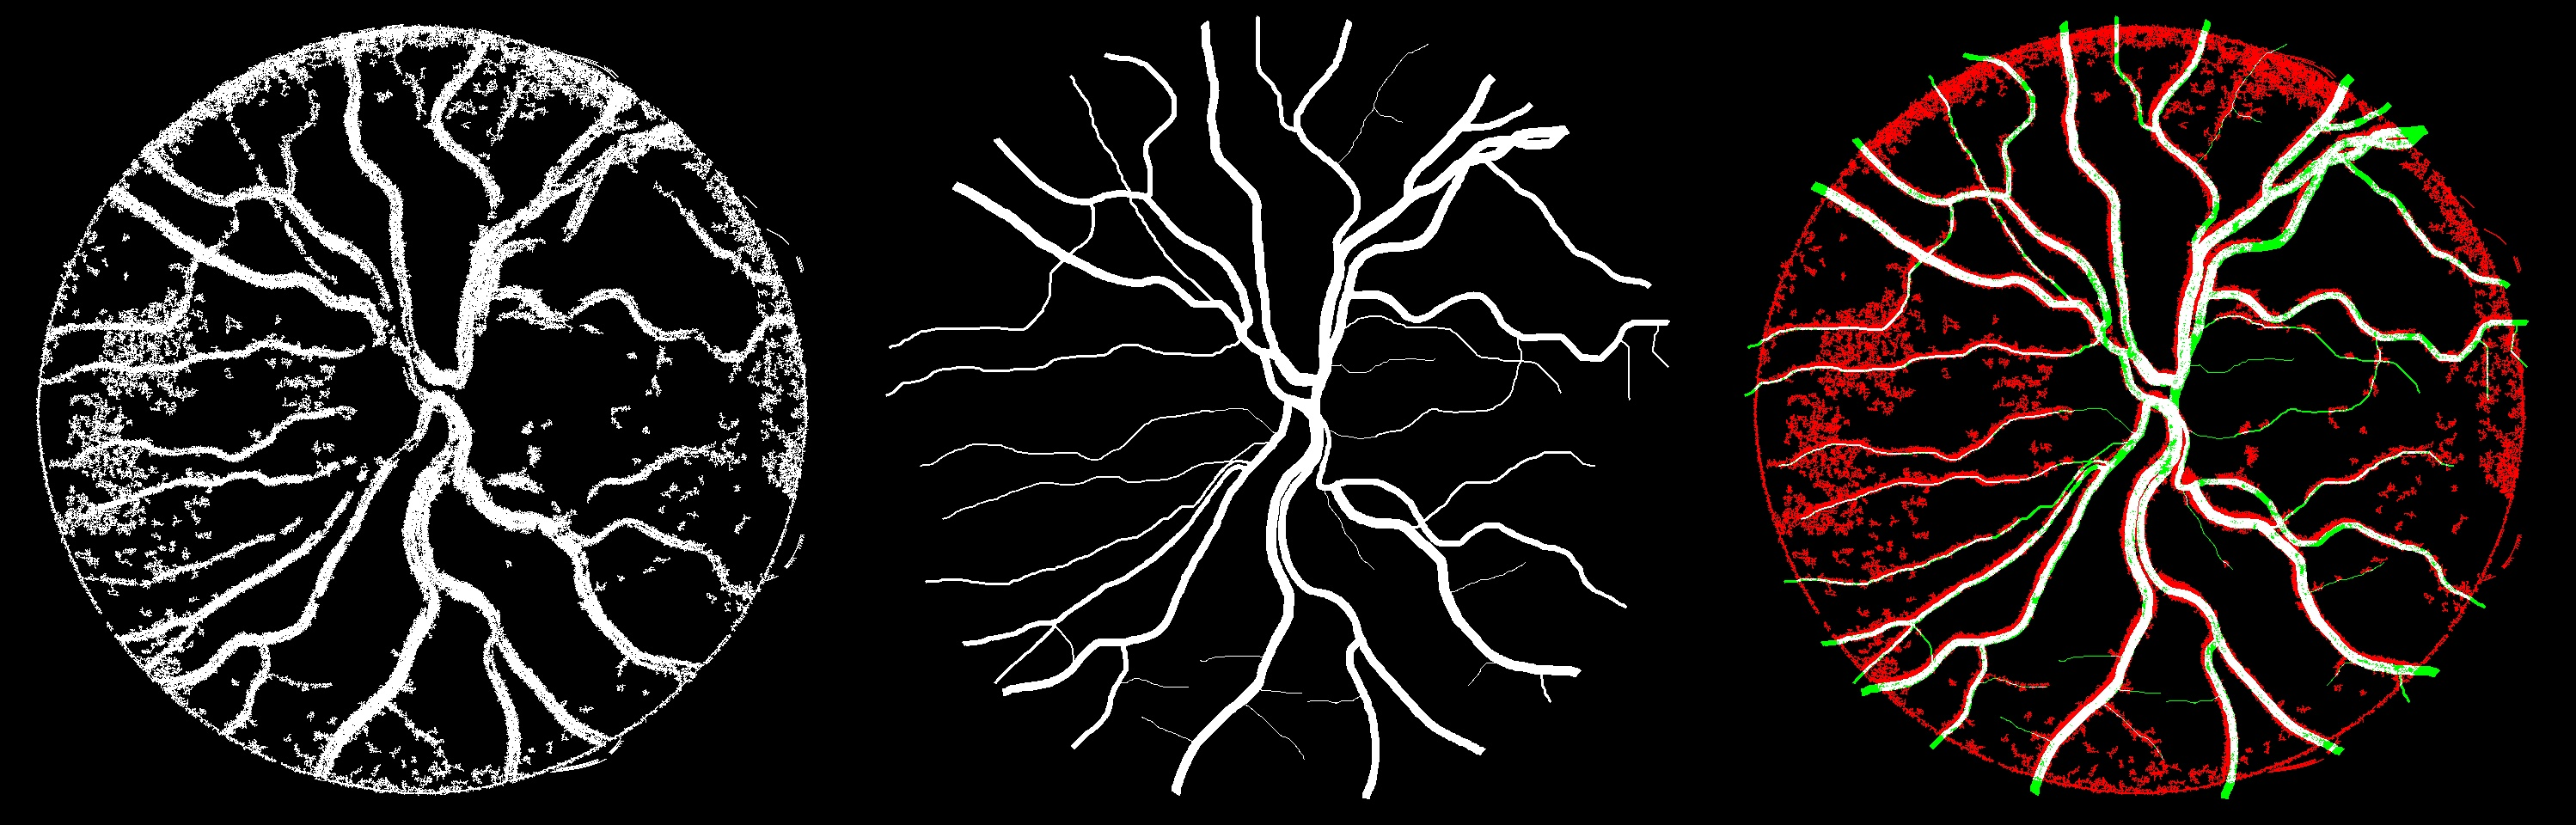

In [90]:
display(Image.open('final.jpg'))
# cv2.namedWindow('images', cv2.WINDOW_NORMAL)
# cv2.resizeWindow('images', 1800, 600)
# cv2.imshow('images', images)

# cv2.waitKey(0)
# cv2.destroyAllWindows()